<a href="https://colab.research.google.com/github/hoaileba/AI-doc/blob/master/RCNN_BBX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from zipfile import ZipFile
!apt install unzip
fileimg = '/content/drive/My Drive/Colab Notebooks/data/dog.zip'
# filelabel = '/content/drive/My Drive/AI_Gen2/Object Detection/RCNN/Airplanes_Annotations.zip'
with ZipFile(fileimg, 'r') as zip:
    # zip.printdir()
    zip.extractall()


Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [0]:
import os,cv2,keras,glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.vgg16 import VGG16

vggmodel = VGG16(weights = 'imagenet', include_top = False)

# for layers in (vggmodel.layers)[:15]:
#     print (layers)
#     layers.trainable = False
input_layer = tf.keras.layers.Input(shape = (224,224,3),name = 'input')
flatten = tf.keras.layers.Flatten()

dens1 = tf.keras.layers.Dense(2048,activation = 'relu')
drop = tf.keras.layers.Dropout(0.5)
dens2 = tf.keras.layers.Dense(1024,activation = 'relu')


X = vggmodel(input_layer)
X1 = flatten(X)
X1 = dens1(X1)
X1 = drop(X1)
X1 = dens2(X1) 

X2 = flatten(X)

# X = vggmodel.layers[-2].output    
predictions = Dense(2, activation = "softmax",name = 'out1')(X1)
bbox = Dense(4,kernel_regularizer=tf.keras.regularizers.l2(1000),name = 'out2')(X2)
model_final = Model(inputs = input_layer, outputs = [predictions,bbox])
opt = Adam(lr = 0.0001)
model_final.compile(loss ={'out1':tf.keras.losses.categorical_crossentropy,'out2':'mse'}, optimizer = opt, metrics = {'out1': "accuracy",'out2':'mse'})
model_final.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   multiple             14714688    input[0][0]                      
__________________________________________________________________________________________________
flatten (Flatten)               (None, 25088)        0           vgg16[1][0]                      
                                                                 vgg16[1][0]                      
__________________________________________________________________________________________________
dense (Dense)                

In [0]:

def get_iou(bb1, bb2):


    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    # assert iou <= 1.0
    # assert iou >= 0.0
    return iou

In [0]:
# path = "/content/data_dog"
# annot = "/content/label_dog"
import os

dirVal = '/content/boundingBox'
dirN = '/content/pre'
dirValImage = '/content/pre/0'
dirValLabel = '/content/pre/1'
dirTrue = dirVal+'/True'
dirPred = dirVal+'/Pred'
os.mkdir(dirVal)
os.mkdir(dirN)
os.mkdir(dirValImage)
os.mkdir(dirValLabel)
os.mkdir(dirTrue)
os.mkdir(dirPred)

In [0]:
path_image = '/content/data_dog'
path_label = '/content/label_dog'

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

def read_txt(path_label):

      # print(fileI, fileL)
      # img = cv2.imread(i)

      grTrue = []
      f = open(path_label, "r")
      data = []
      for ind in f:
        data.append(ind)

      num_ob = int(data[0])
      for id in range(num_ob):
        co = data[id+1].split(' ')
        # print(co[0])
        num = []
        for fi in co:
          if fi != '\n':
            n = float(fi)
            num.append(float(fi))
        x1 = int(num[0]*224)
        y1 = int(num[1]*224)
        x2 = int(num[2]*224)
        y2 = int(num[3]*224)
        # print(x1,y1,x2,y2)
        grTrue.append({'x1':x1,'y1':y1, 'x2':x2 , 'y2' : y2}) 
      return grTrue    
def get_data(path_image, path_label):
    X_train = []
    y_train = []
    dem = 0
    fi = 0
    bb_path = '/content/boundingBox/Pred/'
    True_path = '/content/boundingBox/True/'
    for i in (os.listdir(path_image)):
        # if i.startswith("airplane"):
            dem += 1
            print(dem,end=' ')
            # if dem >= 600:
            #     break
            print(i)
            # break
            img = cv2.imread(os.path.join(path_image, i))
            ss.setBaseImage(img)
            ss.switchToSelectiveSearchQuality()
            result = ss.process()
            #read_label_csv
            gtvalue = read_txt(path_label+'/'+(i.split(".")[0]+".txt"))
            #select region to train
            tflag = 0
            fflag = 0
            flag = 0
            count = 0
            fcount = 0
            # print (len(result))
            imgtmp = img.copy()
            # if dem == 20 :
            #   break
            file_txt = i.split('.')[0]+'.txt'
            print(file_txt)
            # if dem == 2 :
            #   break
            file_bb = open(bb_path+file_txt,'w+')
            for  e,region in enumerate(result):
              if e < 2000:
                for gt in gtvalue:
                    x, y, w, h = region
                    IoU = get_iou(gt, {"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    # print (IoU)
                    if count <  30:
                        if IoU >= 0.75:
                            # cv2.rectangle(imgtmp, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                            
                            img_train = img[y:y+h , x:x+w]
                            resize = cv2.resize(img_train, (224, 224), interpolation = cv2.INTER_AREA)
                            # X_train.append(resize)
                            # y_train.append(1)
                            count += 1
                            fi+=1
                            file_image_name = '/content/pre/1/'+ str(fi)+'.jpg'
                            cv2.imwrite(file_image_name,resize)
                            # file_bb = open(bb_path+file_txt,'w+')
                            file_bb.write(str(x)+" ")
                            file_bb.write(str(y)+" ")
                            file_bb.write(str(w)+" ")
                            file_bb.write(str(h)+" ")
                            file_bb.write(str(IoU)+" ")
                            file_bb.write("1\n")
                            # file_bb.close()
                            # file_bb = open(bb_path+str(fi)+'.txt','w+')
                            # file_bb = open(True_path+str(fi)+'.txt','w+')
                            # file_bb.write(str(gt['x1'])+" ")
                            # file_bb.write(str(gt['y1'])+" ")
                            # file_bb.write(str(gt['x2'])+" ")
                            # file_bb.write(str(gt['y2']))
                            # file_bb.close()
                            
                    else:
                        tflag = 1
                    if fcount < 30:
                        if IoU <= 0.4:
                            img_train = img[y:y+h , x:x+w]
                            resize = cv2.resize(img_train, (224, 224), interpolation = cv2.INTER_AREA)
                            # X_train.append(resize)
                            # y_train.append(0)
                            # count += 1
                            fi+=1
                            fcount+=1
                            file_image_name = '/content/pre/0/'+ str(fi)+'.jpg'
                            cv2.imwrite(file_image_name,resize)
                            file_bb.write(str(x)+" ")
                            file_bb.write(str(y)+" ")
                            file_bb.write(str(w)+" ")
                            file_bb.write(str(h)+" ")
                            file_bb.write(str(IoU)+" ")
                            file_bb.write("0\n")
                            # file_bb = open(True_path+str(fi)+'.txt','w+')
                            # file_bb.write(str(gt['x1'])+" ")
                            # file_bb.write(str(gt['y1'])+" ")
                            # file_bb.write(str(gt['x2'])+" ")
                            # file_bb.write(str(gt['y2']))
                            # file_bb.close()
                    else:
                        fflag = 1
                    # break
                if tflag == 1 and fflag == 1:
                    # print ("perfect")
                    break
            print (fi)
            file_bb.close()
            if fi == 20 :
              break
            # break   
           # cv2_imshow(imgtmp)

       
# get_d
get_data(path_image, path_label)
# print (len(X_train))

In [0]:
f = open('/content/boundingBox/Pred/2484.txt','r')
# print(f.read())
ar = []

for fi in f:
  ar.append(fi)
  stri = ar[0].split(' ')
print(stri)

['0', '16', '163', '211', '1']


In [0]:
!zip -r /content/file.zip /content/pre

In [0]:
!zip -r /content/file1.zip /content/boundingBox/Pred


In [0]:
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	pick = []
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]

	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	while len(idxs) > 0:
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		overlap = (w * h) / area[idxs[:last]]
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	return boxes[pick].astype("int")

In [0]:
file1 = glob.glob("/content/pre/0/*.jpg")
file0 = glob.glob("/content/pre/1/*.jpg")
from keras.utils import to_categorical
class_= np.array(['0','1'])

import os
files = []
for f in file1:
  files.append(f)
for f in file0:
  files.append(f)
# print()
import random
random.shuffle(files)
# sep = tf.strings.split(files[100],'/')[-2]
# print(len(files))
# print(int(sep))
def read_txt(path_label):

      path_label = path_label.numpy().decode('utf-8')
      path_region = path_label.split('/')[-1]
      path_region = '/content/boundingBox/Pred/'+path_region
      # print(path_label)
      # grTrue = []

      f = open(path_label, "r")
      ar = []
      for fi in f:
        ar.append(fi)
        num = ar[0].split(' ')
      f.close()


      fr = open(path_region, "r")
      ar = []
      for fi in fr:
        ar.append(fi)
        num_r = ar[0].split(' ')
      
      x = np.array([float(i) for i in num ])
      x1 = np.array([float(i) for i  in num_r  ])
      x[2] = x[2] - x[0]
      x[3] = x[3] - x[1]
      t = [0,0,0,0]
      t[0] = (x[0] -  x1[0])/x[2]
      t[1] = (x[1] - x1[1])/x[3]
      t[2] = np.math.log(x[2]/x1[2])
      t[3] = np.math.log(x[3]/x1[3])
      # x1 = int(num[0])
      # y1 = int(num[1])
      # x2 = int(num[2])
      # y2 = int(num[3])
      # # print(x1,y1,x2,y2)
      # grTrue.append([x1,y1,x2,y2])

      # print(x,x1)
      f.close()
      return np.array(t)

def Process(img_path):
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image,channels = 3)
  # image = tf.cast(image,tf.float32)/255.0
  image = tf.image.resize(image,(224,224))
  parts = tf.strings.split(img_path, os.path.sep)
  y=parts[-2]==class_
  filename = parts[-1]
  name = tf.strings.split(filename,'.')
  
  true_ = '/content/boundingBox/True/'+ name[0] +'.txt'

  x1 = tf.py_function(read_txt,[true_],tf.float32)

  return image,float(y),x1


def gen(data):
  data = data.batch(100).repeat()
  for b in data:
    yield {'input':b[0]},{'out1':b[1],'out2':b[2]}

data_list=tf.data.Dataset.from_tensor_slices(files).map(Process,num_parallel_calls=tf.data.experimental.AUTOTUNE)
# data_list = data_list.shuffle(100)
print(len(files))
data = gen(data_list)
for img,lab ,t in data_list.take(1):
  print(t.numpy())

In [0]:
from keras.utils import np_utils
X_train = np.array(X_train)
y_train = np.array(y_train)
y_train = np_utils.to_categorical(y_train, 2)
print (X_train.shape)
print (y_train.shape)

(78352, 224, 224, 3)
(78352, 2)


In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# print(y_train[0]
# model_checkpoint = ModelCheckpoint('vanhocvp.hdf5', monitor='loss',verbose=1, save_best_only=True)
# checkpoint = ModelCheckpoint("/content/drive/rcnn_vgg16_v4.hdf5", monitor='loss',verbose=1, save_best_only=True)
# early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit(data, steps_per_epoch=78384//100, epochs= 4, verbose= 1,shuffle = True)

NameError: ignored

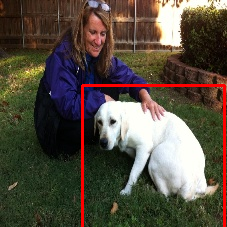

In [0]:

model_final.save("model.h5")
img = cv2.imread("/content/85bcf3cd6540ec7d.jpg")
# print (i)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

ss.setBaseImage(img)
ss.switchToSelectiveSearchQuality()
ssresults = ss.process()
imout = img.copy()
rects = []
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_final.predict(img)
        
        if out[0][0][1] >=0.98:
            # print (out)
            # cv2.rectangle(imout, (x, y), (x+w, y+h), (0,0, 255),2)
            x_predict,y_predict,w_predict,h_predict=x+out[1][0][0]*w,y+out[1][0][1]*h,w*np.math.exp(out[1][0][2]),h*np.math.exp(out[1][0][3])
            rects.append([x_predict,y_predict,w_predict+x_predict,y_predict+h_predict])

            # cv2_imshow(imout)
            # cv2.waitkey(200)
all_rect = np.array(rects).reshape(-1,4)
box = non_max_suppression_fast(all_rect,0.46)
for e in box:
  x ,y, xx,yy = e
  cv2.rectangle(imout, (x, y), (xx, yy), (0,0, 255),2)
cv2_imshow(imout)
# plt.figure()
           